A few code is copied from Sreeni https://www.youtube.com/watch?v=L5iV5BHkMzM&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=27

In [ ]:
!pip install focal_loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, add, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, multiply
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [3]:
import os,cv2, random
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import normalize

In [ ]:
from focal_loss import BinaryFocalLoss

# Load data volume and preprocessing

In [4]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume.npy', 'rb') as f:
    train_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume.npy', 'rb') as f:
    train_masks = np.load(f)

In [5]:
# Normalize image (Always normalize your images when doing deep learning!!!)
# Expand dimension
# image_dataset = np.expand_dims(normalize(train_images, axis=1), 3) # only the images need normalization
# mask_dataset = np.expand_dims(train_masks, 3)/255

image_dataset = np.expand_dims(train_images / np.max(train_images), 3) # only the images need normalization
mask_dataset = np.expand_dims(train_masks, 3)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, 
                                                    test_size = 0.20, random_state = 0)

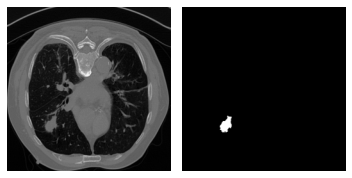

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(5,3))

image_number = random.randint(0,len(train_images))

ax[0].imshow(train_images[image_number,:,:], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(train_masks[image_number,:,:], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

# Loss and Metrics

In [6]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  dice_coef = 2 * (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
  return dice_coef

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

In [7]:
def jaccard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  jaccard_coef = (intersection + 1.0)/ (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)  # 1 is probably used to avoid nan for 0/0 
  return jaccard_coef


# Function Definition

CONV - (BN) - Activation - CONV - (BN) - Activation - Dropout (If enabled)

In [ ]:
def conv_block(input, filter_size, filter, dropout_rate, batch_norm = False):
  conv = Conv2D(filter, (filter_size, filter_size), padding='same', kernel_initializer='he_normal')(input)
  if batch_norm == True:
    conv = BatchNormalization(axis = 3)(conv)
  conv = Activation('relu')(conv)

  conv = Conv2D(filter, (filter_size, filter_size), padding='same', kernel_initializer='he_normal')(conv)
  if batch_norm == True:
    conv = BatchNormalization(axis = 3)(conv)
  conv = Activation('relu')(conv)

  if dropout_rate > 0:
    conv = Dropout(dropout_rate)(conv)

  return conv

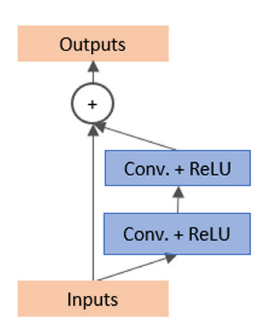

In [ ]:
def res_conv_block(input, filter_size, filter, dropout_rate, batch_norm=False):
  '''
  The structure is shown in the picture above.

  Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    *2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation
  '''
  # Conv path
  conv = Conv2D(filter, (filter_size, filter_size), padding='same', kernel_initializer='he_normal')(input)
  if batch_norm == True:
    conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)

  conv = Conv2D(filter, (filter_size, filter_size), padding='same', kernel_initializer='he_normal')(conv)
  if batch_norm == True:
    conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)

  if dropout_rate > 0:
    conv = Dropout(dropout_rate)(conv)
  
  shortcut = Conv2D(filter, (1,1), padding='same')(input)
  if batch_norm == True:
    shortcut = BatchNormalization()(shortcut)
  
  respath = add([shortcut, conv])
  respath = Activation('relu')(respath)
  return respath


In [ ]:
def gating_signal(input, out_size, batch_norm=False):
  '''
  return the gating feature map with the same dimension as the up layer feature map
  kind of like the Conv2DTranspose
  '''
  x = Conv2D(out_size, (1,1), padding='same')(input)
  if batch_norm == True:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

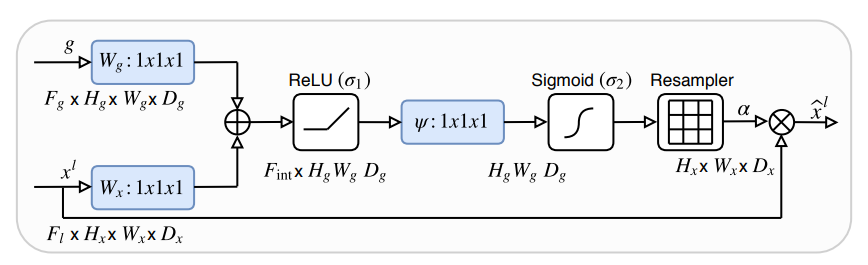

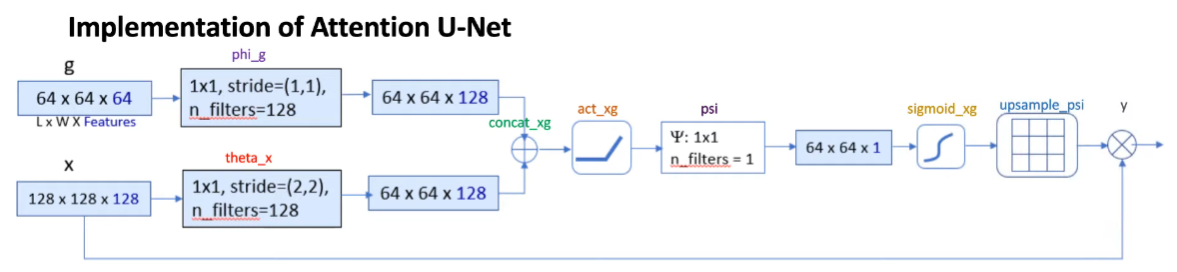

refer to https://www.youtube.com/watch?v=KOF38xAvo8I&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=26

In [ ]:
def attention_block(x, gating, inter_shape):
  shape_x = K.int_shape(x) # same usage as numpy.shape
  shape_g = K.int_shape(gating)

  # Getting x to the same shape as the gating signal. 
  theta_x = Conv2D(inter_shape, (2,2), padding='same', strides=(2,2))(x)

  # Getting gating signal to the same number of filter
  phi_g = Conv2D(inter_shape, (1,1), padding='same')(gating)

  concat_xg = add([phi_g, theta_x]) # this is actually add not concatenate.

  act_xg = Activation('relu')(concat_xg)

  psi = Conv2D(1, (1,1), padding='same')(act_xg)
  
  sigmoid_xg = Activation('sigmoid')(psi)
  shape_sigmoid = K.int_shape(sigmoid_xg)

  upsample_psi = UpSampling2D(size = (shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

  y = multiply([upsample_psi, x])

  result = Conv2D(shape_x[3], (1,1), padding='same')(y)
  result = BatchNormalization()(result)

  return result


# Define Model

## Attention Unet

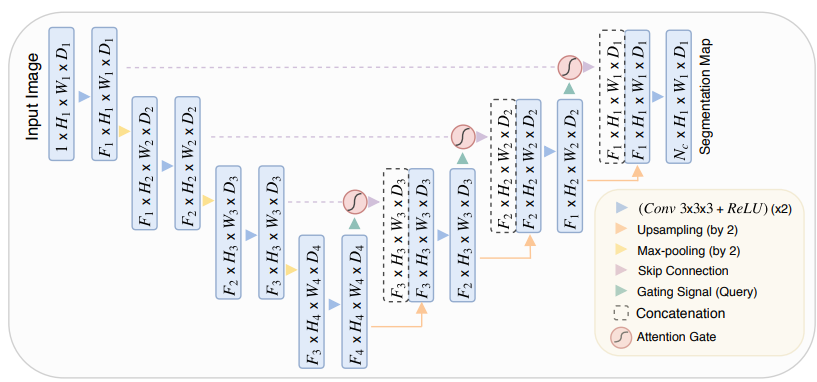

In [ ]:
def Attention_Unet(H, W, C, dropout_rate=0.0, batch_norm=True):

  FILTER_NUM = 64
  FILTER_SIZE = 3
  UP_SAMPLE_SIZE = 2

  inputs = Input((H,W,C))

  # Contractive path
  c1 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = conv_block(p1, FILTER_SIZE, FILTER_NUM*2, dropout_rate, batch_norm)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = conv_block(p2, FILTER_SIZE, FILTER_NUM*4, dropout_rate, batch_norm)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = conv_block(p3, FILTER_SIZE, FILTER_NUM*8, dropout_rate, batch_norm)
  p4 = MaxPooling2D((2,2))(c4)

  # Bottleneck
  c5 = conv_block(p4, FILTER_SIZE, FILTER_NUM*16, dropout_rate, batch_norm)

  # Expansive path
  g6 = gating_signal(c5, FILTER_NUM*8, batch_norm=False)
  att6 = attention_block(c4, g6, FILTER_NUM*8)
  u6 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE), name='u6')(c5)
  u6 = concatenate([att6, u6])
  c6 = conv_block(u6, FILTER_SIZE, FILTER_NUM*8, dropout_rate, batch_norm)

  g7 = gating_signal(c6, FILTER_NUM*4, batch_norm=False)
  att7 = attention_block(c3, g7, FILTER_NUM*4)
  u7 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c6)
  u7 = concatenate([att7, u7])
  c7 = conv_block(u7, FILTER_SIZE, FILTER_NUM*4, dropout_rate, batch_norm)

  g8 = gating_signal(c7, FILTER_NUM*2, batch_norm=False)
  att8 = attention_block(c2, g8, FILTER_NUM*2)
  u8 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c7)
  u8 = concatenate([att8, u8])
  c8 = conv_block(u8, FILTER_SIZE, FILTER_NUM*2, dropout_rate, batch_norm)

  g9 = gating_signal(c8, FILTER_NUM, batch_norm=False)
  att9 = attention_block(c1, g9, FILTER_NUM*2)
  u9 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c8)
  u9 = concatenate([att9, u9])
  c9 = conv_block(u9, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

  outputs = Conv2D(1, (1,1), padding='same')(c9)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('sigmoid')(outputs)  #Change to softmax for multichannel

  model = Model(inputs = [inputs], outputs = [outputs])

#   model.summary()

  return model

# Train Attention Unet model

In [ ]:
# model takes in 3 parameters H, W, C
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [ ]:
attentionUnet = Attention_Unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
attentionUnet.compile(optimizer='adam', 
                      loss='binary_crossentropy',
                      metrics=[dice_coef, jaccard_coef, 'accuracy'])

In [ ]:
attentionUnet.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [ ]:
# Define callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

checkpoint_path = '/content/checkpoint/AttentionUnet_lung_TestNotVal_BCE_loss_epoch_{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True)

earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

logs = CSVLogger('attentionU_TestNotVal_BCE_logs.csv', 
                 separator=',', append=False)

callbacks = [checkpoint, logs, earlystop]

In [ ]:
import datetime
start1 = datetime.datetime.now()

history_lung = attentionUnet.fit(X_train, y_train, batch_size=2, epochs=50, verbose=1, validation_split = 0.2, callbacks=callbacks)

stop1 = datetime.datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

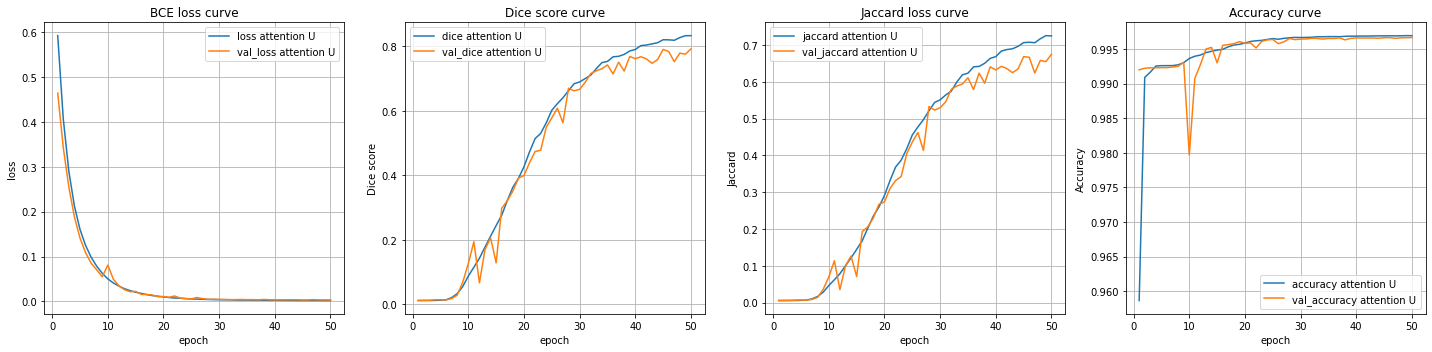

In [ ]:
loss = history_lung.history['loss'] 
val_loss = history_lung.history['val_loss']
dice = history_lung.history['dice_coef'] 
val_dice = history_lung.history['val_dice_coef'] 
jaccard = history_lung.history['jaccard_coef'] 
val_jaccard = history_lung.history['val_jaccard_coef'] 
accu = history_lung.history['accuracy'] 
val_accu = history_lung.history['val_accuracy'] 

epoch = range(1, len(loss) + 1)
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(epoch, loss)
plt.plot(epoch, val_loss)

plt.grid()
plt.legend(['loss attention U', 'val_loss attention U'], loc = 'best')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('BCE loss curve')

plt.subplot(142)
plt.plot(epoch, dice)
plt.plot(epoch, val_dice)

plt.grid()
plt.legend(['dice attention U', 'val_dice attention U'], loc = 'best')
plt.xlabel('epoch')
plt.ylabel('Dice score')
plt.title('Dice score curve')

plt.subplot(143)
plt.plot(epoch, jaccard)
plt.plot(epoch, val_jaccard)

plt.grid()
plt.legend(['jaccard attention U', 'val_jaccard attention U'], loc = 'best')
plt.xlabel('epoch')
plt.ylabel('Jaccard')
plt.title('Jaccard loss curve')

plt.subplot(144)
plt.plot(epoch, accu)
plt.plot(epoch, val_accu)

plt.grid()
plt.legend(['accuracy attention U', 'val_accuracy attention U'], loc = 'best')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy curve')

plt.tight_layout()
plt.show()

## Evaluation

In [ ]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume_negative.npy', 'rb') as f:
    negative_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume_negative.npy', 'rb') as f:
    negative_masks = np.load(f)

X_test_negative = np.expand_dims(negative_images / np.max(train_images), 3) # only the images need normalization
y_test_negative = np.expand_dims(negative_masks, 3)

In [ ]:
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_images.npy', 'rb') as f:
    X_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_masks.npy', 'rb') as f:
    y_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_images.npy', 'rb') as f:
    X_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_masks.npy', 'rb') as f:
    y_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_images.npy', 'rb') as f:
    X_test_L = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_masks.npy', 'rb') as f:
    y_test_L = np.load(f)

In [ ]:
def measure(model, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L):
    
    y_pred = model.predict(X_test)
    negative_pred = model.predict(X_test_negative)
    y_pred_S = model.predict(X_test_S) # running on the positive test set
    y_pred_M = model.predict(X_test_M) # running on the positive test set
    y_pred_L = model.predict(X_test_L) # running on the positive test set

    y_pred_thresholded = y_pred > 0.5

    # IoU (Jaccard)
    intersection = np.logical_and(y_test, y_pred_thresholded)
    union = np.logical_or(y_test, y_pred_thresholded)
    iou = np.sum(intersection) / np.sum(union)

    # Dice
    y_true_f = y_test.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    dice_coef = 2 * (intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)

    # Prec, recall, accu
    precision = np.sum(intersection) / np.sum(y_pred_thresholded)
    recall = np.sum(intersection) / np.sum(y_test)

    corr = np.logical_not(np.logical_xor(y_test, y_pred_thresholded))
    accu = int(np.sum(corr)) / (332 * (256 ** 2))

    # Negative dataset
    negative_pred_thresholded = negative_pred > 0.5
    corrN = np.logical_not(np.logical_xor(y_test_negative, negative_pred_thresholded))
    accuN = int(np.sum(corrN)) / (150 * (256 ** 2))

    # SML dataset
    y_true_Sf = y_test_S.flatten()
    y_pred_Sf = y_pred_S.flatten()
    intersection = np.sum(y_true_Sf * y_pred_Sf)
    dice_coef_S = 2 * (intersection + 1e-9) / (np.sum(y_true_Sf) + np.sum(y_pred_Sf) + 1e-9)
    
    y_true_Mf = y_test_M.flatten()
    y_pred_Mf = y_pred_M.flatten()
    intersection = np.sum(y_true_Mf * y_pred_Mf)
    dice_coef_M = 2 * (intersection + 1e-9) / (np.sum(y_true_Mf) + np.sum(y_pred_Mf) + 1e-9)

    y_true_Lf = y_test_L.flatten()
    y_pred_Lf = y_pred_L.flatten()
    intersection = np.sum(y_true_Lf * y_pred_Lf)
    dice_coef_L = 2 * (intersection + 1e-9) / (np.sum(y_true_Lf) + np.sum(y_pred_Lf) + 1e-9)

    return dice_coef, dice_coef_S, dice_coef_M, dice_coef_L, iou, precision, recall, accu, accuN

In [ ]:
# attentionUnet = MultiResUnet(256,256,1)
attentionUnet.load_weights('/content/drive/MyDrive/FYP_colab/Lung_Nodule_Segmentation_Project/AttentionUnet_weights.hdf5')

In [ ]:
measure(attentionUnet, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L)

(0.7535115189511827,
 0.2820985648564849,
 0.6518901072731913,
 0.8122223994570975,
 0.6075152859656691,
 0.9062739147324855,
 0.7376760210183515,
 0.9973654689559017,
 0.9996985880533854)

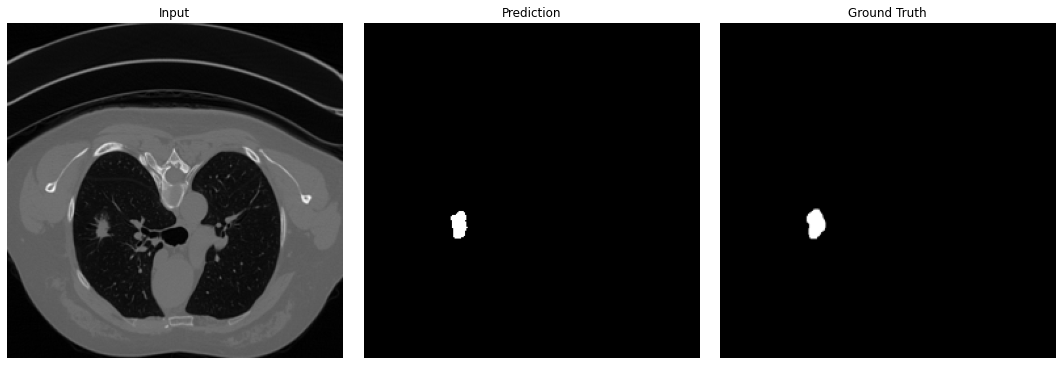

In [ ]:
num = np.random.randint(len(X_test))
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(X_test[num,:,:,0], cmap = plt.cm.gray)
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(y_pred_thresholded[num,:,:,0], cmap = plt.cm.gray)
plt.axis('off')
plt.title('Prediction')
plt.subplot(133)
plt.imshow(y_test[num,:,:,0], cmap = plt.cm.gray)
plt.axis('off')
plt.title('Ground Truth')

plt.tight_layout()
plt.show()

## Attention Res Unet 

In [ ]:
def Attention_Res_Unet(H, W, C, dropout_rate=0.0, batch_norm=True):

  FILTER_NUM = 64
  FILTER_SIZE = 3
  UP_SAMPLE_SIZE = 2

  inputs = Input((H,W,C))

  # Contractive path
  c1 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = res_conv_block(p1, FILTER_SIZE, FILTER_NUM*2, dropout_rate, batch_norm)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = res_conv_block(p2, FILTER_SIZE, FILTER_NUM*4, dropout_rate, batch_norm)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = res_conv_block(p3, FILTER_SIZE, FILTER_NUM*8, dropout_rate, batch_norm)
  p4 = MaxPooling2D((2,2))(c4)

  # Bottleneck
  c5 = res_conv_block(p4, FILTER_SIZE, FILTER_NUM*16, dropout_rate, batch_norm)

  # Expansive path
  g6 = gating_signal(c5, FILTER_NUM*8, batch_norm=False)
  att6 = attention_block(c4, g6, FILTER_NUM*8)
  u6 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c5)
  u6 = concatenate([att6, u6])
  c6 = res_conv_block(u6, FILTER_SIZE, FILTER_NUM*8, dropout_rate, batch_norm)

  g7 = gating_signal(c6, FILTER_NUM*4, batch_norm=False)
  att7 = attention_block(c3, g7, FILTER_NUM*4)
  u7 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c6)
  u7 = concatenate([att7, u7])
  c7 = res_conv_block(u7, FILTER_SIZE, FILTER_NUM*4, dropout_rate, batch_norm)

  g8 = gating_signal(c7, FILTER_NUM*2, batch_norm=False)
  att8 = attention_block(c2, g8, FILTER_NUM*2)
  u8 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c7)
  u8 = concatenate([att8, u8])
  c8 = res_conv_block(u8, FILTER_SIZE, FILTER_NUM*2, dropout_rate, batch_norm)

  g9 = gating_signal(c8, FILTER_NUM, batch_norm=False)
  att9 = attention_block(c1, g9, FILTER_NUM*2)
  u9 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c8)
  u9 = concatenate([att9, u9])
  c9 = res_conv_block(u9, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

  outputs = Conv2D(1, (1,1), padding='same')(c9)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('sigmoid')(outputs)  #Change to softmax for multichannel

  model = Model(inputs = [inputs], outputs = [outputs])

#   model.summary()

  return model

## Train

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [ ]:
attention_res_unet = Attention_Res_Unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
attention_res_unet.compile(optimizer=Adam(learning_rate = 1e-2), 
                      loss='binary_crossentropy', 
                      metrics=[dice_coef, jaccard_coef, 'accuracy'])

In [ ]:
# Define callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

checkpoint_path = '/content/atten_resU_checkpoint/AttentionResUnet_lung_BCE_epoch_{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True)

earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

logs = CSVLogger('attentionRes_lung_BCE_loss_Logs.csv', 
                 separator=',', append=False)

callbacks = [checkpoint, logs, earlystop]

In [ ]:
import datetime
start2 = datetime.datetime.now()

history_res = attention_res_unet.fit(X_train, y_train, batch_size=10, epochs=100, verbose=1, validation_split = 0.2, callbacks=callbacks)

stop2 = datetime.datetime.now()
#Execution time of the model 
execution_time = stop2-start2
print("Execution time is: ", execution_time)

## Evaluation

In [ ]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume_negative.npy', 'rb') as f:
    negative_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume_negative.npy', 'rb') as f:
    negative_masks = np.load(f)

X_test_negative = np.expand_dims(negative_images / np.max(train_images), 3) # only the images need normalization
y_test_negative = np.expand_dims(negative_masks, 3)

In [ ]:
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_images.npy', 'rb') as f:
    X_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_masks.npy', 'rb') as f:
    y_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_images.npy', 'rb') as f:
    X_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_masks.npy', 'rb') as f:
    y_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_images.npy', 'rb') as f:
    X_test_L = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_masks.npy', 'rb') as f:
    y_test_L = np.load(f)

In [ ]:
def measure(model, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L):
    
    y_pred = model.predict(X_test)
    negative_pred = model.predict(X_test_negative)
    y_pred_S = model.predict(X_test_S) # running on the positive test set
    y_pred_M = model.predict(X_test_M) # running on the positive test set
    y_pred_L = model.predict(X_test_L) # running on the positive test set

    y_pred_thresholded = y_pred > 0.5

    # IoU (Jaccard)
    intersection = np.logical_and(y_test, y_pred_thresholded)
    union = np.logical_or(y_test, y_pred_thresholded)
    iou = np.sum(intersection) / np.sum(union)

    # Dice
    y_true_f = y_test.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    dice_coef = 2 * (intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)

    # Prec, recall, accu
    precision = np.sum(intersection) / np.sum(y_pred_thresholded)
    recall = np.sum(intersection) / np.sum(y_test)

    corr = np.logical_not(np.logical_xor(y_test, y_pred_thresholded))
    accu = int(np.sum(corr)) / (332 * (256 ** 2))

    # Negative dataset
    negative_pred_thresholded = negative_pred > 0.5
    corrN = np.logical_not(np.logical_xor(y_test_negative, negative_pred_thresholded))
    accuN = int(np.sum(corrN)) / (150 * (256 ** 2))

    # SML dataset
    y_true_Sf = y_test_S.flatten()
    y_pred_Sf = y_pred_S.flatten()
    intersection = np.sum(y_true_Sf * y_pred_Sf)
    dice_coef_S = 2 * (intersection + 1e-9) / (np.sum(y_true_Sf) + np.sum(y_pred_Sf) + 1e-9)
    
    y_true_Mf = y_test_M.flatten()
    y_pred_Mf = y_pred_M.flatten()
    intersection = np.sum(y_true_Mf * y_pred_Mf)
    dice_coef_M = 2 * (intersection + 1e-9) / (np.sum(y_true_Mf) + np.sum(y_pred_Mf) + 1e-9)

    y_true_Lf = y_test_L.flatten()
    y_pred_Lf = y_pred_L.flatten()
    intersection = np.sum(y_true_Lf * y_pred_Lf)
    dice_coef_L = 2 * (intersection + 1e-9) / (np.sum(y_true_Lf) + np.sum(y_pred_Lf) + 1e-9)

    return dice_coef, dice_coef_S, dice_coef_M, dice_coef_L, iou, precision, recall, accu, accuN

In [ ]:
attention_res_unet.load_weights('/content/drive/MyDrive/FYP_colab/Lung_Nodule_Segmentation_Project/AttentionResUnet_weights.hdf5')

In [ ]:
measure(attention_res_unet, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L) 

(0.7597203232054114,
 0.25748229709798187,
 0.6408818374205962,
 0.8422457638015054,
 0.6913548228581569,
 0.9147781995593741,
 0.8526186680968404,
 0.9979215415127306,
 0.9995553588867188)